# Preprocessing notebook

In [18]:
import polars as pl
import os
from pathlib import Path
from bs4 import BeautifulSoup
import lxml
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import functools
import re
from datetime import datetime
import spacy
import json
import time

from typing import Optional
import wordcloud
import matplotlib.pyplot as plt

from datetime import datetime

In [19]:
# Configuration parameters

treatment_date = datetime(2022, 11, 30)

CONFIG = {
    "input_file": "../data/combined/forums_wo_so.parquet",
    "output_dir": "../data/batched_processing",
    "temp_dir": "../data/batched_processing/temp_combined",
    "log_file": "../data/batched_processing/processing_wo_so_log.json",
    "batch_size": 50000,  # Records per batch
    "total_batches": None,  # Will be calculated
    "completed_batches": [],  # Will track completed batches
}

# Create necessary directories
os.makedirs(CONFIG["output_dir"], exist_ok=True)
os.makedirs(CONFIG["temp_dir"], exist_ok=True)

In [3]:
# Attention: Just do this once to create a comprehensive dataset
if not os.path.exists(CONFIG["input_file"]):
    # Load and combine other forum datasets, assign identifiers
    df_math = pl.read_parquet("../data/math/math.parquet").with_columns(
        pl.lit("Mathematics").alias("forum")
    )
    df_physics = pl.read_parquet("../data/physics/physics.parquet").with_columns(
        pl.lit("Physics").alias("forum")
    )
    df_su = pl.read_parquet("../data/superuser/superuser.parquet").with_columns(
        pl.lit("Superuser").alias("forum")
    )
    df_au = pl.read_parquet("../data/askubuntu/askubuntu.parquet").with_columns(
        pl.lit("Askubuntu").alias("forum")
    )

    pl.concat(
        [df_math, df_physics, df_su, df_au], how="diagonal_relaxed"
    ).write_parquet("../data/combined/forums_wo_so.parquet")

## Preprocessing functions

In [4]:
def extract_text_and_code_optimized(
    html_content: str, forum: str
) -> dict[str, list[str]]:
    """
    Extracts text and technical expressions (code blocks or math) from HTML content.
    Each forum only contains one type of technical expression, never both.
    """
    # Parse HTML
    soup = BeautifulSoup(html_content, "lxml")

    tech_expr = []

    # Handle code expressions for technical forums (i.e., approx. >5% of questions contain code)
    if forum in ["Superuser", "Askubuntu"]:
        # Extract code blocks for technical forums
        elements = soup.find_all("code")
    # Handle math expressions for mathematical forums (i.e., approx. >5% of questions contain math)
    elif forum in ["Mathematics", "Physics"]:
        # Extract LaTeX math expressions for mathematical forums
        elements = soup.find_all("span", class_="math-container")
    else:
        elements = []

    # Process any found elements
    tech_expr = [element.get_text() for element in elements]

    # Remove elements from the HTML
    for element in elements:
        element.replace_with(" ")  # Replace with space to maintain text flow

    # Get remaining text
    clean_text = soup.get_text(separator=" ", strip=True)

    return {"text": clean_text, "tech_expr": tech_expr}

In [5]:
# Initialize stemmer once
stemmer = PorterStemmer()

# Create stopwords set once
standard_stops = set(stopwords.words("english"))
programming_stops = set()  # Add programming-specific stopwords if needed
combined_stops = standard_stops.union(programming_stops)


# Cache for stemmed words
@functools.lru_cache(maxsize=100000)
def cached_stem(word):
    return stemmer.stem(word)


def preprocess_text(text, remove_stops=True):
    """Process text content with optimizations"""

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stop words and apply stemming more efficiently
    if remove_stops:
        # Use generator expression instead of list comprehension
        return " ".join(
            cached_stem(token) for token in tokens if token not in combined_stops
        )
    else:
        # Use generator expression instead of list comprehension
        return " ".join(cached_stem(token) for token in tokens if token)

In [6]:
# Load a small, efficient SpaCy model - disable components you don't need
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Create stopwords set using spaCy instead of NLTK
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
programming_stops = set()  # Add programming-specific stopwords if needed
combined_stops = spacy_stopwords.union(programming_stops)


# Cache for lemmatized words
@functools.lru_cache(maxsize=100000)
def cached_lemmatize(word):
    """Lemmatize a single word and cache the result"""
    # Process the word with the full pipeline to get lemma
    doc = nlp(word)  # Use nlp() instead of nlp.make_doc()
    return doc[0].lemma_


def preprocess_text_spacy(text, remove_stops=True):
    """Process text content with SpaCy lemmatization"""

    # Process the entire text through the pipeline
    doc = nlp(text)  # Use full nlp pipeline instead of just tokenizer

    # Apply lemmatization with stop word removal if needed
    if remove_stops:
        return " ".join(
            token.lemma_  # Access lemma_ directly from processed tokens
            for token in doc
            if token.text not in combined_stops
            and token.text.strip()
            and (
                token.is_alpha or (token.text.isalnum() and len(token.text) > 1)
            )  # Allow alphanumeric tokens
        )
    else:
        return " ".join(
            token.lemma_  # Access lemma_ directly from processed tokens
            for token in doc
            if token.text.strip()
        )

## Complete batch preprocessing pipeline

Use the Polars lazy dataframe implementation to profit from query optimization for large datasets, but still batch it, since it's too much data.

### Batch processing setup

In [7]:
# Enable Polars to use all available threads for maximum performance
pl.Config.set_streaming_chunk_size(CONFIG["batch_size"])


# Initialize processing state
def initialize_state():
    """Initialize or load the processing state"""
    if os.path.exists(CONFIG["log_file"]):
        with open(CONFIG["log_file"], "r") as f:
            return json.load(f)
    else:
        # Count total rows to calculate batches
        row_count = (
            pl.scan_parquet(CONFIG["input_file"]).select(pl.len()).collect().item()
        )
        total_batches = (row_count + CONFIG["batch_size"] - 1) // CONFIG["batch_size"]

        state = {
            "total_rows": row_count,
            "total_batches": total_batches,
            "completed_batches": [],
            "start_time": datetime.now().isoformat(),
            "last_processed_time": None,
            "processing_stats": {
                "avg_batch_time_seconds": None,
                "estimated_time_remaining": None,
            },
        }
        save_state(state)
        return state


def save_state(state):
    """Save the current processing state"""
    state["last_processed_time"] = datetime.now().isoformat()
    with open(CONFIG["log_file"], "w") as f:
        json.dump(state, f, indent=2)

### Pre-processing pipeline

In [8]:
def process_batch(batch_id, state):
    """Process a single batch of data"""
    if batch_id in state["completed_batches"]:
        print(f"Batch {batch_id} already processed, skipping.")
        return

    start_time = time.time()
    print(f"Processing batch {batch_id}/{state['total_batches']}...")

    # Calculate row offset for this batch
    offset = batch_id * CONFIG["batch_size"]

    # Process the batch
    batch_df = (
        pl.scan_parquet(CONFIG["input_file"])
        .slice(offset, CONFIG["batch_size"])
        .select(
            [
                "Id",
                "CreationDate",
                "Score",
                "ViewCount",
                "Title",
                "Body",
                "Tags",
                "AnswerCount",
                "CommentCount",
                "forum",
            ]
        )
        .with_columns(
            pl.struct(["Body", "forum"])
            .map_elements(
                lambda s: extract_text_and_code_optimized(s["Body"], s["forum"]),
                return_dtype=pl.Struct(
                    [
                        pl.Field("text", pl.Utf8),
                        pl.Field("tech_expr", pl.List(pl.Utf8)),
                    ]
                ),
            )
            .alias("content"),
            pl.col("Tags")
            .str.strip_prefix("|")
            .str.strip_suffix("|")
            .str.split("|")
            .alias("tag_list"),
        )
        .with_columns(
            pl.col("content").struct.field("text").alias("clean_text"),
            pl.col("content").struct.field("tech_expr").alias("tech_expr"),
            pl.col("tag_list").list.len().alias("tag_count"),
        )
        .with_columns(
            pl.col("tech_expr").list.join("").str.len_chars().alias("expr_length"),
            pl.col("Body").str.len_chars().alias("body_length"),
            pl.col("Title").str.len_chars().alias("title_length"),
        )
        .drop(["Body", "Tags", "content"])
        .with_columns(
            pl.col("clean_text")
            .str.to_lowercase()
            .str.strip_chars()
            .replace("", None)
            .map_elements(
                preprocess_text_spacy,
                return_dtype=pl.Utf8(),
                skip_nulls=True,
            )
            .alias("processed_text")
        )
        .collect(
            streaming=True,
            no_optimization=False,
        )
    )

    # Save the processed batch to a parquet file
    output_file = f"{CONFIG['temp_dir']}/batch_{batch_id:04d}.parquet"
    batch_df.write_parquet(output_file)

    # Update state
    state["completed_batches"].append(batch_id)

    # Calculate processing statistics
    end_time = time.time()
    batch_time = end_time - start_time

    # Update average batch time if we have processed batches
    if not state["processing_stats"]["avg_batch_time_seconds"]:
        state["processing_stats"]["avg_batch_time_seconds"] = batch_time
    else:
        # Exponential moving average with alpha=0.3
        avg_time = state["processing_stats"]["avg_batch_time_seconds"]
        state["processing_stats"]["avg_batch_time_seconds"] = (
            avg_time * 0.7 + batch_time * 0.3
        )

    # Estimate time remaining
    remaining_batches = state["total_batches"] - len(state["completed_batches"])
    state["processing_stats"]["estimated_time_remaining"] = (
        remaining_batches * state["processing_stats"]["avg_batch_time_seconds"]
    )

    # Save updated state
    save_state(state)

    print(f"Batch {batch_id} completed in {batch_time:.2f} seconds.")
    print(
        f"Estimated time remaining: {state['processing_stats']['estimated_time_remaining'] / 3600:.2f} hours"
    )

    return batch_df


### Batching

In [9]:
def merge_processed_batches(state):
    """Merge all processed batches into a single parquet file"""
    print("Merging processed batches...")

    # List all batch files in order
    batch_files = []
    for batch_id in range(state["total_batches"]):
        file_path = f"{CONFIG['temp_dir']}/batch_{batch_id:04d}.parquet"
        if os.path.exists(file_path):
            batch_files.append(file_path)

    if not batch_files:
        print("No processed batches found to merge.")
        return

    # Read and concatenate all batches
    merged_df = pl.concat([pl.read_parquet(file) for file in batch_files])

    # Save the merged dataframe
    output_file = f"{CONFIG['output_dir']}/forums_wo_so_processed_batch.parquet"
    merged_df.write_parquet(output_file)

    print(f"Merged {len(batch_files)} batches into {output_file}")
    return merged_df


def run_batch_processing(start_batch=None, end_batch=None):
    """Run the batch processing pipeline"""
    state = initialize_state()

    # Determine batch range to process
    if start_batch is None:
        start_batch = 0
    if end_batch is None:
        end_batch = state["total_batches"] - 1

    print(f"Starting batch processing from batch {start_batch} to {end_batch}")
    print(f"Total rows: {state['total_rows']}, Total batches: {state['total_batches']}")

    try:
        for batch_id in range(start_batch, end_batch + 1):
            process_batch(batch_id, state)
    except KeyboardInterrupt:
        print("\nProcessing interrupted. Progress has been saved.")
        print(
            f"Completed {len(state['completed_batches'])}/{state['total_batches']} batches."
        )
        return state

    print("All specified batches completed!")
    return state

### States

In [10]:
# Function to get processing progress/stats
def get_processing_status():
    """Get current processing status and stats"""
    if os.path.exists(CONFIG["log_file"]):
        with open(CONFIG["log_file"], "r") as f:
            state = json.load(f)

        completed = len(state["completed_batches"])
        total = state["total_batches"]

        print(f"Progress: {completed}/{total} batches ({completed / total * 100:.1f}%)")

        if state["processing_stats"]["avg_batch_time_seconds"]:
            avg_time = state["processing_stats"]["avg_batch_time_seconds"]
            print(f"Average batch processing time: {avg_time:.2f} seconds")

            remaining_batches = total - completed
            est_time = remaining_batches * avg_time
            print(
                f"Estimated time remaining: {est_time / 3600:.2f} hours ({est_time / 60:.2f} minutes)"
            )

        start_time = datetime.fromisoformat(state["start_time"])
        elapsed = (datetime.now() - start_time).total_seconds()
        print(f"Total elapsed time: {elapsed / 3600:.2f} hours")

        return state
    else:
        print(
            "No processing log found. Run initialize_state() to start new processing."
        )
        return None

## Run batch processing

In [11]:
# Initialize state (do this first)
state = initialize_state()

# Get current status
get_processing_status()

Progress: 0/11 batches (0.0%)
Total elapsed time: 0.18 hours


{'total_rows': 514453,
 'total_batches': 11,
 'completed_batches': [],
 'start_time': '2025-03-10T01:09:29.787595',
 'last_processed_time': '2025-03-10T01:09:29.787628',
 'processing_stats': {'avg_batch_time_seconds': None,
  'estimated_time_remaining': None}}

In [12]:
state = run_batch_processing()

Starting batch processing from batch 0 to 10
Total rows: 514453, Total batches: 11
Processing batch 0/11...


/tmp/ipykernel_19343/2755206073.py:72: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 0 completed in 455.78 seconds.
Estimated time remaining: 1.27 hours
Processing batch 1/11...


/tmp/ipykernel_19343/2755206073.py:72: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 1 completed in 477.09 seconds.
Estimated time remaining: 1.16 hours
Processing batch 2/11...


/tmp/ipykernel_19343/2755206073.py:72: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 2 completed in 468.70 seconds.
Estimated time remaining: 1.03 hours
Processing batch 3/11...


/tmp/ipykernel_19343/2755206073.py:72: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 3 completed in 475.50 seconds.
Estimated time remaining: 0.91 hours
Processing batch 4/11...


/tmp/ipykernel_19343/2755206073.py:72: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 4 completed in 482.04 seconds.
Estimated time remaining: 0.79 hours
Processing batch 5/11...


/tmp/ipykernel_19343/2755206073.py:72: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 5 completed in 503.08 seconds.
Estimated time remaining: 0.67 hours
Processing batch 6/11...


/tmp/ipykernel_19343/2755206073.py:72: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 6 completed in 495.30 seconds.
Estimated time remaining: 0.54 hours
Processing batch 7/11...


/tmp/ipykernel_19343/2755206073.py:72: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 7 completed in 510.28 seconds.
Estimated time remaining: 0.41 hours
Processing batch 8/11...


/tmp/ipykernel_19343/2755206073.py:72: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 8 completed in 515.23 seconds.
Estimated time remaining: 0.28 hours
Processing batch 9/11...


/tmp/ipykernel_19343/2755206073.py:72: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 9 completed in 460.26 seconds.
Estimated time remaining: 0.14 hours
Processing batch 10/11...


/tmp/ipykernel_19343/2755206073.py:72: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


Batch 10 completed in 136.76 seconds.
Estimated time remaining: 0.00 hours
All specified batches completed!


In [13]:
# When all batches are done, merge them
merged_df = merge_processed_batches(initialize_state())

Merging processed batches...
Merged 11 batches into ../data/batched_processing/forums_wo_so_processed_batch.parquet


## EDA

In [21]:
df = pl.read_parquet(
    CONFIG["output_dir"] + "/forums_wo_so_processed_batch.parquet"
).with_columns(pl.col("CreationDate").cast(pl.Datetime))

In [15]:
# Calculate average text length
avg_text_length = df["processed_text"].str.len_chars().mean()
print(f"Average text length: {avg_text_length}")

Average text length: 338.6784188948445


### Wordclouds

In [16]:
def word_freq(text):
    from collections import Counter

    # Assuming 'text' is your large string
    words = text.split()
    word_freq = Counter(words)

    # If you want a regular dictionary instead of Counter
    return dict(word_freq)

In [17]:
def generate_wordcloud(title: str, text: str) -> None:
    wc = wordcloud.WordCloud(
        width=2400,
        height=1200,
        background_color="white",
        colormap="viridis",
        # stopwords=STOP_WORDS,
        mode="RGBA",
    )

    wc.generate_from_frequencies(word_freq(text))

    if title:
        wc.to_file(f"../imgs/wordclouds/{title}.png")

    # Set the figure size
    plt.figure(figsize=(16, 10))

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")

    plt.show()

#### Mathematics

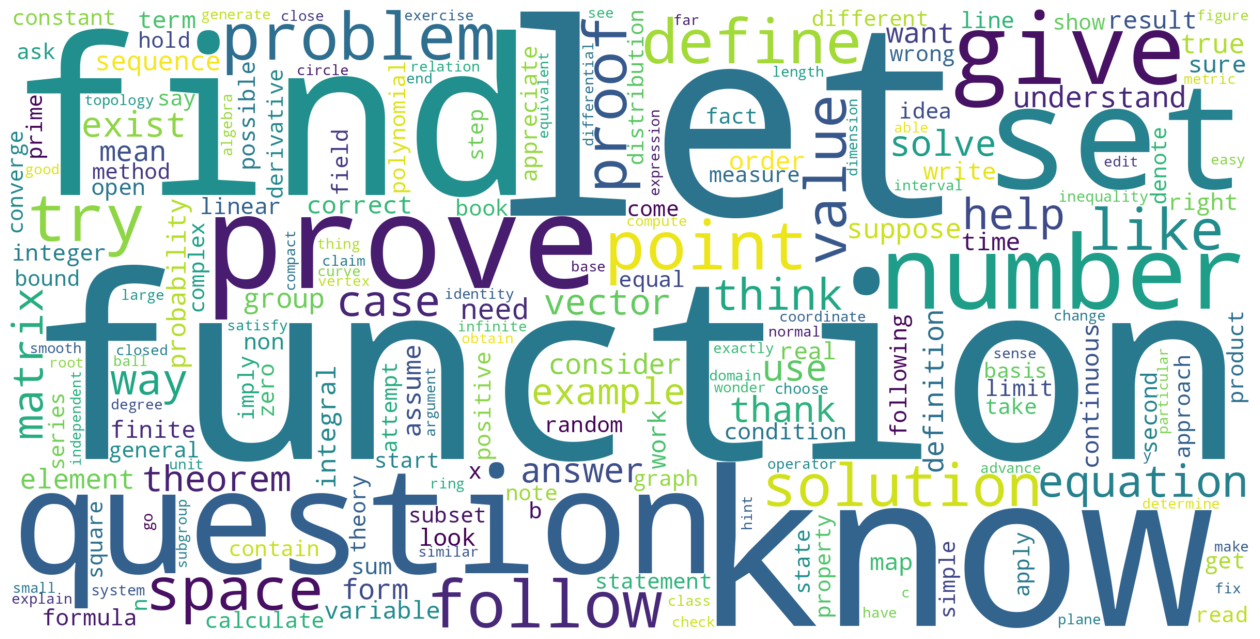

In [22]:
# Pre Mathematics word cloud
text = (
    df.filter(
        (pl.col("forum") == "Mathematics") & (pl.col("CreationDate") <= treatment_date)
    )
    .select(
        pl.col("processed_text")
        .filter(pl.col("processed_text").is_not_null())
        .str.concat(" ")
    )
    .item()
)

generate_wordcloud("wc_math_pre", text)

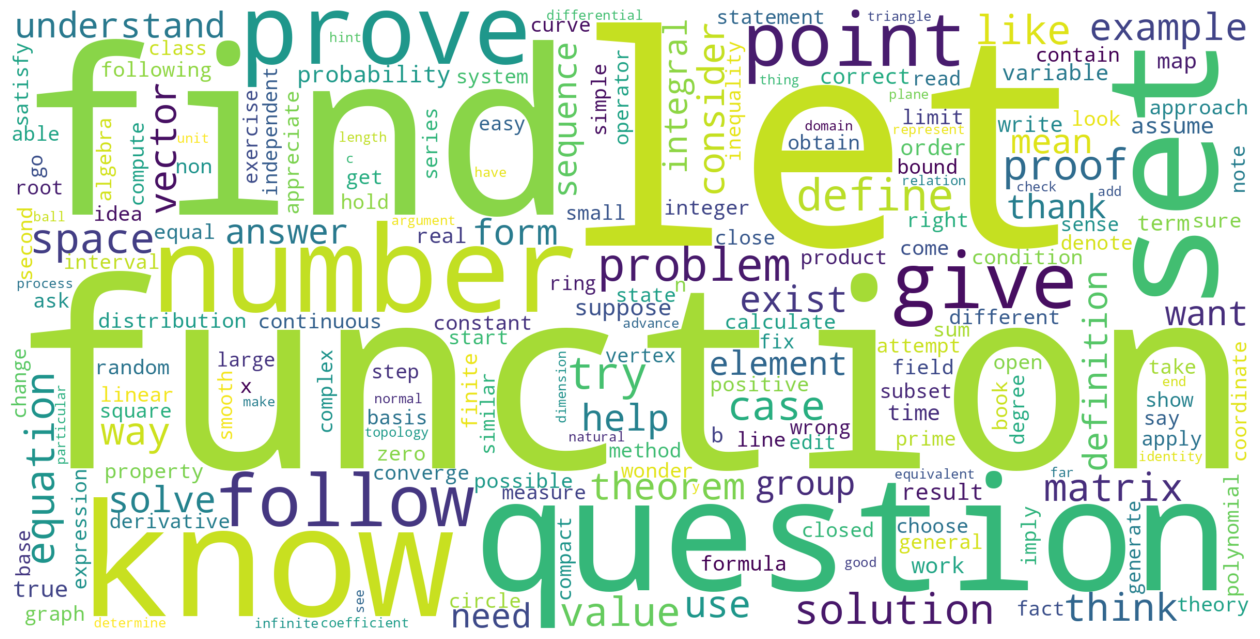

In [23]:
# Post Mathematics word cloud
text = (
    df.filter(
        (pl.col("forum") == "Mathematics") & (pl.col("CreationDate") > treatment_date)
    )
    .select(
        pl.col("processed_text")
        .filter(pl.col("processed_text").is_not_null())
        .str.concat(" ")
    )
    .item()
)

generate_wordcloud("wc_math_post", text)

#### Physics

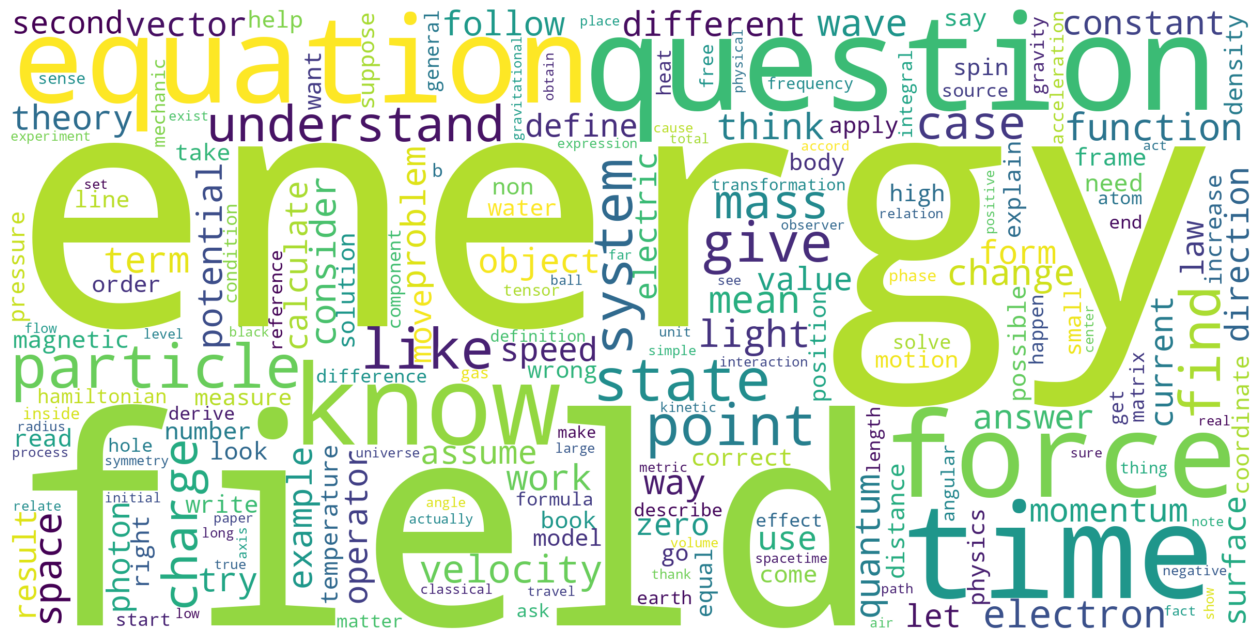

In [24]:
# Pre Physics word cloud
text = (
    df.filter(
        (pl.col("forum") == "Physics") & (pl.col("CreationDate") <= treatment_date)
    )
    .select(
        pl.col("processed_text")
        .filter(pl.col("processed_text").is_not_null())
        .str.concat(" ")
    )
    .item()
)

generate_wordcloud("wc_physics_pre", text)

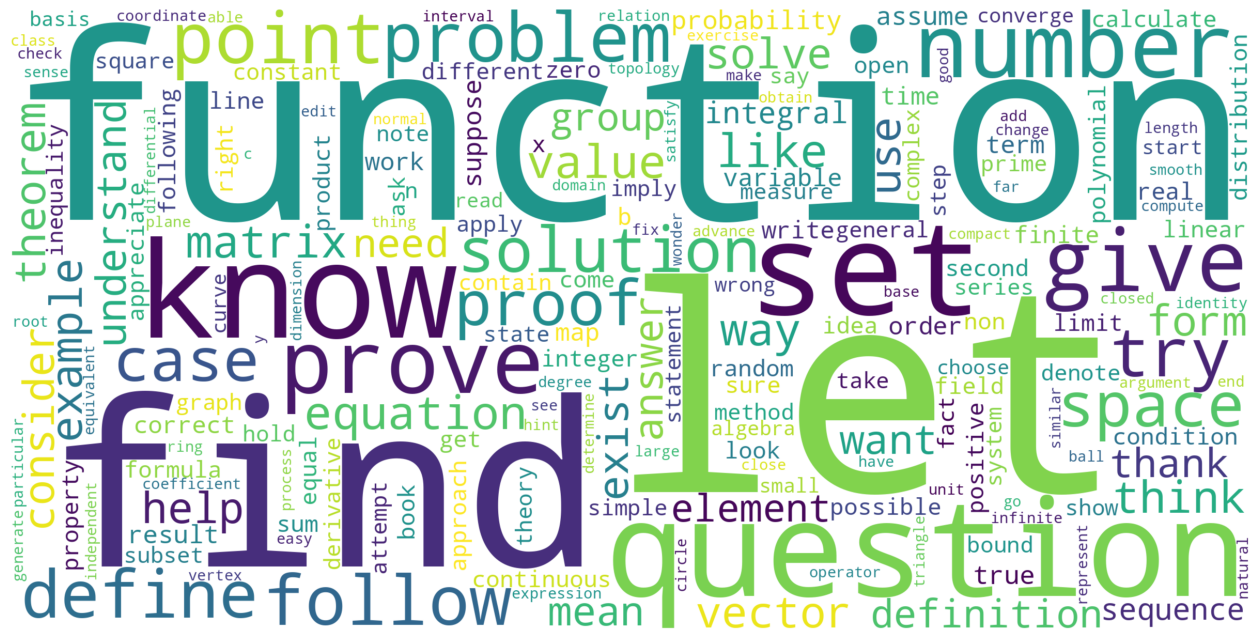

In [25]:
# Post Mathematics word cloud
text = (
    df.filter(
        (pl.col("forum") == "Mathematics") & (pl.col("CreationDate") > treatment_date)
    )
    .select(
        pl.col("processed_text")
        .filter(pl.col("processed_text").is_not_null())
        .str.concat(" ")
    )
    .item()
)

generate_wordcloud("wc_physics_post", text)

#### Superuser

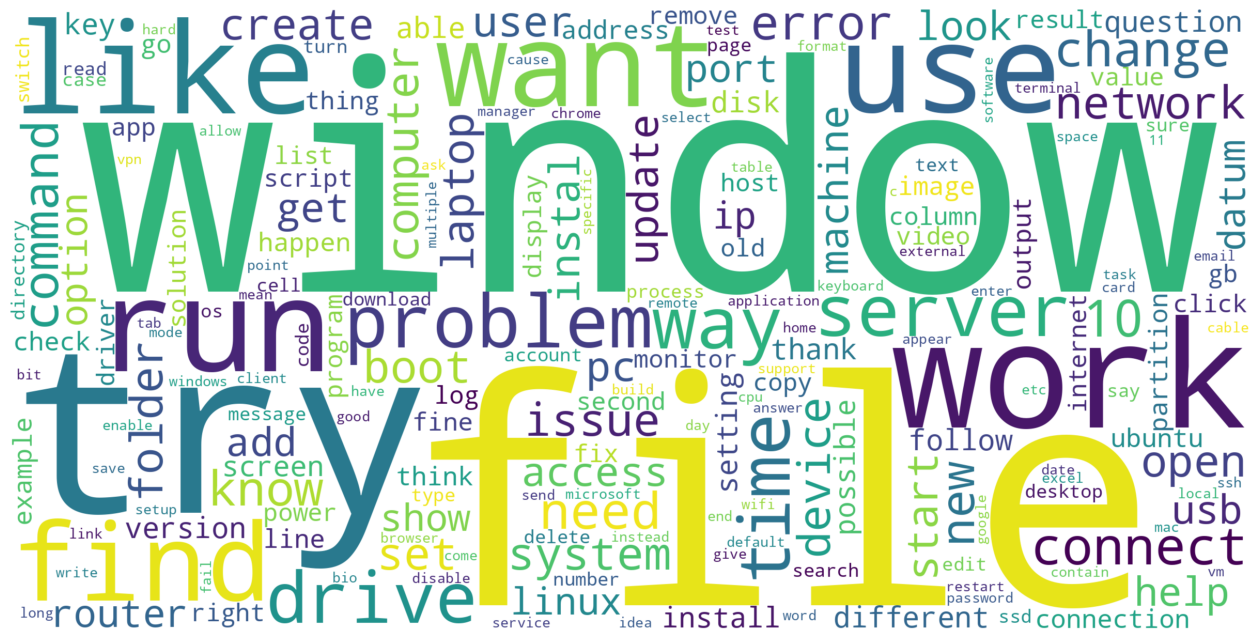

In [26]:
# Pre Superuser word cloud
text = (
    df.filter(
        (pl.col("forum") == "Superuser") & (pl.col("CreationDate") <= treatment_date)
    )
    .select(
        pl.col("processed_text")
        .filter(pl.col("processed_text").is_not_null())
        .str.concat(" ")
    )
    .item()
)

generate_wordcloud("wc_su_pre", text)

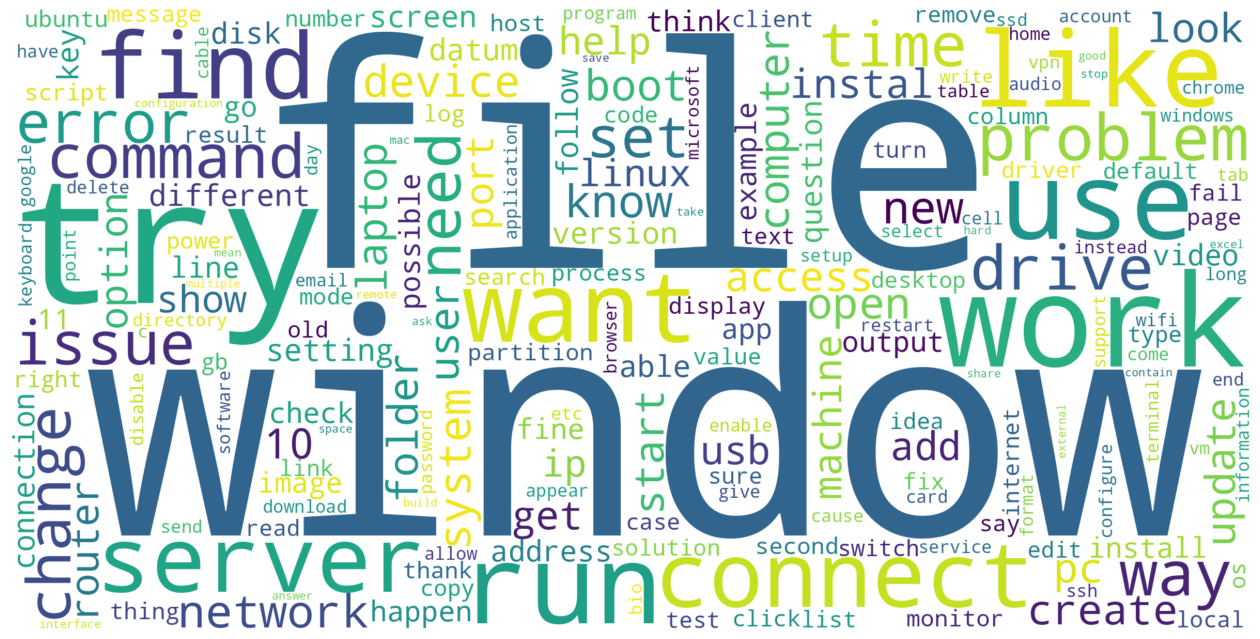

In [27]:
# Post Superuser word cloud
text = (
    df.filter(
        (pl.col("forum") == "Superuser") & (pl.col("CreationDate") > treatment_date)
    )
    .select(
        pl.col("processed_text")
        .filter(pl.col("processed_text").is_not_null())
        .str.concat(" ")
    )
    .item()
)

generate_wordcloud("wc_su_post", text)

#### Askubuntu

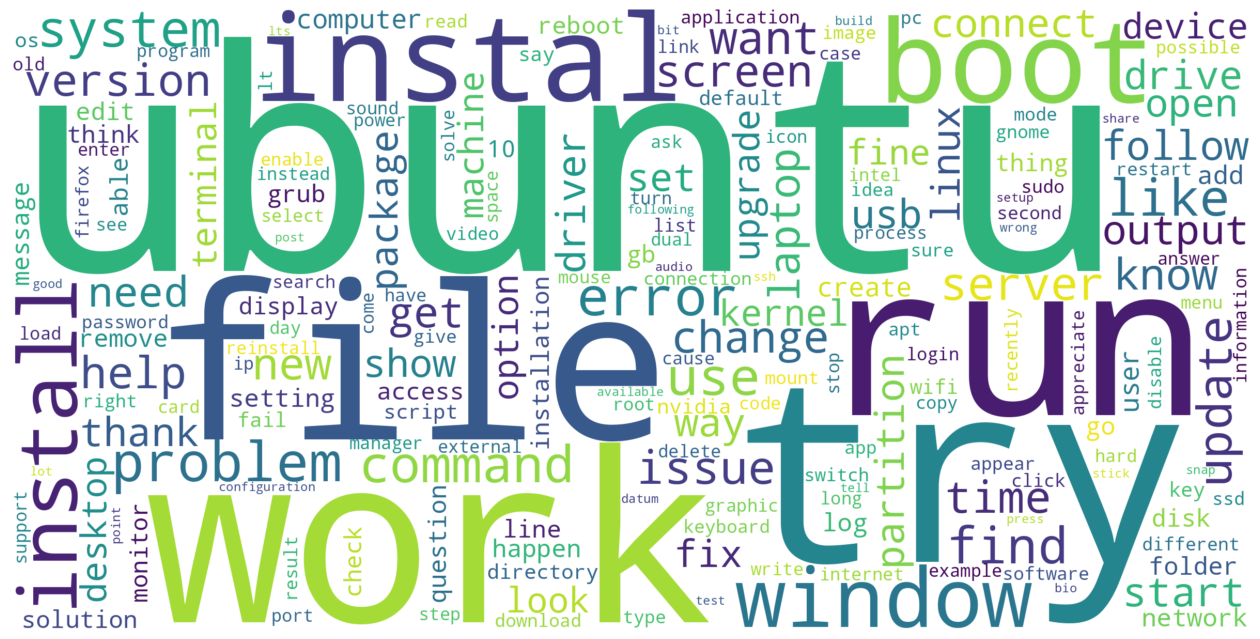

In [28]:
# Pre Askubuntu word cloud
text = (
    df.filter(
        (pl.col("forum") == "Askubuntu") & (pl.col("CreationDate") <= treatment_date)
    )
    .select(
        pl.col("processed_text")
        .filter(pl.col("processed_text").is_not_null())
        .str.concat(" ")
    )
    .item()
)

generate_wordcloud("wc_au_pre", text)

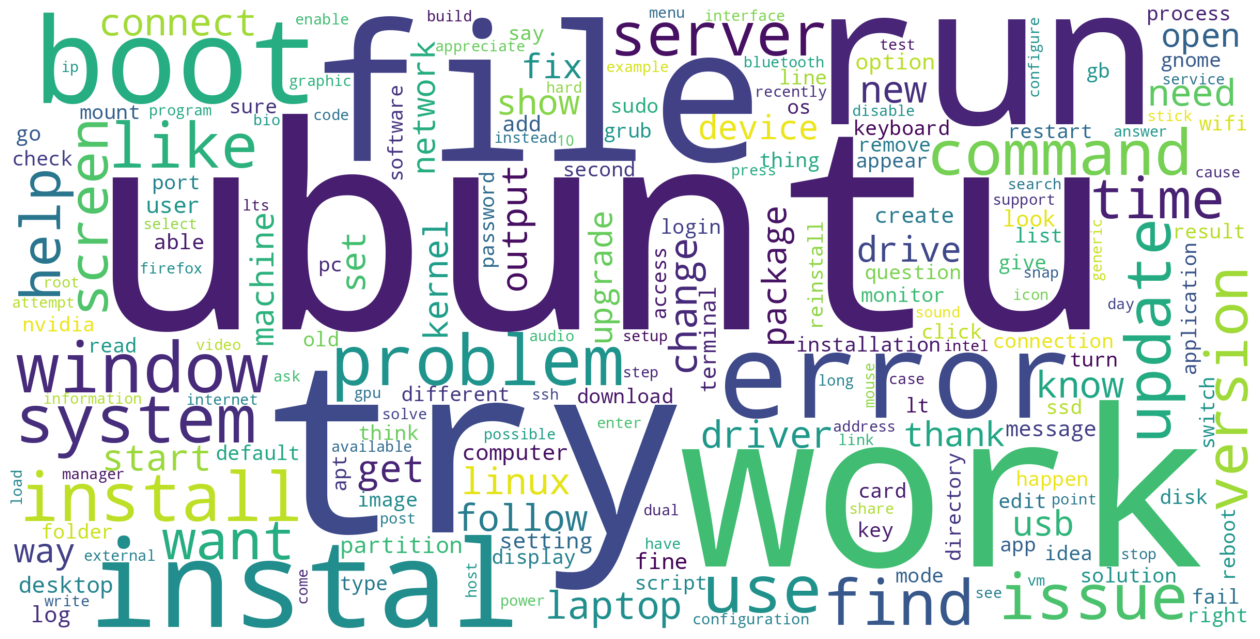

In [29]:
# Post Askubuntu word cloud
text = (
    df.filter(
        (pl.col("forum") == "Askubuntu") & (pl.col("CreationDate") > treatment_date)
    )
    .select(
        pl.col("processed_text")
        .filter(pl.col("processed_text").is_not_null())
        .str.concat(" ")
    )
    .item()
)

generate_wordcloud("wc_au_post", text)